In [1]:
import json
import tempfile
from os import path

import geopandas as gpd
import pandas as pd
import salem
import seaborn as sns
import swiss_uhi_utils as suhi
import swisslandstats as sls
import xarray as xr
from tqdm import tqdm

from lausanne_greening_scenarios.invest import utils as invest_utils
from lausanne_greening_scenarios.scenarios import utils as scenarios_utils

# register tqdm with pandas to be able to use `progress_apply`
tqdm.pandas()

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
scenario_metrics_filepath = '../data/interim/scenario-metrics.csv'
scenario_lulc_filepath = '../data/interim/scenario-da.nc'
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
ref_et_da_filepath = '../data/interim/invest/ref-et.nc'
t_da_filepath = '../data/processed/tair-ucm.nc'
calibrated_params_filepath = '../data/interim/invest/calibrated-params.json'

agglom_extent_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
statpop_filepath = '../data/raw/statpop/statpop-2019.csv'

In [3]:
scenario_metrics_df = pd.read_csv(scenario_metrics_filepath)
scenario_metrics_df = scenario_metrics_df.groupby(['interaction', 'change_prop']).mean().drop('scenario_run', axis=1).reset_index()
metrics_cols = scenario_metrics_df.columns[2:6]

In [4]:
scenario_lulc_da = xr.open_dataarray(scenario_lulc_filepath)
rio_meta = scenario_lulc_da.attrs.copy()
scenario_lulc_da = scenario_lulc_da.mean('scenario_run').round().astype(rio_meta['dtype'])
scenario_dims = scenario_lulc_da.coords.dims[:-2]
scenario_lulc_da.attrs = rio_meta

In [5]:
t_da = xr.open_dataarray(t_da_filepath)
# t_ref = t_da.min(dim=['x', 'y'])
# uhi_max = t_da.max(dim=['x', 'y']) - t_ref
# max_uhi_date = t_da.isel(time=uhi_max.argmax())['time'].dt.strftime('%Y-%m-%d').item()

# ref_et_da = xr.open_dataarray(ref_et_da_filepath).sel(time=max_uhi_date)
# tmp_dir = tempfile.mkdtemp()
# ref_et_raster_filepath = invest_utils.dump_ref_et_raster(
#     ref_et_da, max_uhi_date, tmp_dir, invest_utils.get_da_rio_meta(ref_et_da))
hottest_day = t_da.isel(time=t_da.groupby('time').max(dim=['x', 'y']).argmax())['time'].dt.strftime('%Y-%m-%d').item()
# hottest_day = '2019-07-24'
t_ref = t_da.sel(time=hottest_day).min(dim=['x', 'y']).item()
uhi_max = t_da.sel(time=hottest_day).max(dim=['x', 'y']).item() - t_ref

ref_et_da = xr.open_dataarray(ref_et_da_filepath).sel(time=hottest_day)
tmp_dir = tempfile.TemporaryDirectory()
# ref_et_raster_filepath = invest_utils.dump_ref_et_raster(
#     ref_et_da, hottest_day, tmp_dir, invest_utils.get_da_rio_meta(ref_et_da))
ref_et_raster_filepath = '../data/interim/ref_eto_2019-07-24.tif'

In [6]:
t_da = xr.open_dataarray(t_da_filepath)
t_ref = t_da.min(dim=['x', 'y'])
uhi_max = t_da.max(dim=['x', 'y']) - t_ref
max_uhi_date = t_da.isel(time=uhi_max.argmax())['time'].dt.strftime('%Y-%m-%d').item()

ref_et_da = xr.open_dataarray(ref_et_da_filepath).sel(time=max_uhi_date)
tmp_dir = tempfile.mkdtemp()
ref_et_raster_filepath = invest_utils.dump_ref_et_raster(
    ref_et_da, max_uhi_date, tmp_dir, invest_utils.get_da_rio_meta(ref_et_da))

In [7]:
with open(calibrated_params_filepath) as src:
    ucm_params = json.load(src)

In [8]:
sw = scenarios_utils.ScenarioWrapper(scenario_lulc_da, t_da.sel(time=max_uhi_date), biophysical_table_filepath, ref_et_raster_filepath, ucm_params)

In [9]:
scenario_metrics_df['T_avg'] = scenario_metrics_df.progress_apply(sw.compute_t_avg, axis=1)

  0%|          | 0/22 [00:00<?, ?it/s]

  9%|▉         | 2/22 [00:31<05:18, 15.91s/it]

 14%|█▎        | 3/22 [01:06<06:48, 21.50s/it]

 18%|█▊        | 4/22 [01:41<07:42, 25.69s/it]

 23%|██▎       | 5/22 [02:16<08:01, 28.30s/it]

 27%|██▋       | 6/22 [02:49<07:57, 29.86s/it]

 32%|███▏      | 7/22 [03:22<07:42, 30.84s/it]

 36%|███▋      | 8/22 [03:55<07:19, 31.40s/it]

 41%|████      | 9/22 [04:28<06:55, 31.93s/it]

 45%|████▌     | 10/22 [05:02<06:29, 32.47s/it]

 50%|█████     | 11/22 [05:34<05:56, 32.45s/it]

 55%|█████▍    | 12/22 [06:07<05:25, 32.56s/it]

 59%|█████▉    | 13/22 [06:40<04:52, 32.53s/it]

 64%|██████▎   | 14/22 [07:15<04:27, 33.41s/it]

 68%|██████▊   | 15/22 [07:49<03:55, 33.63s/it]

 73%|███████▎  | 16/22 [08:26<03:26, 34.46s/it]

 77%|███████▋  | 17/22 [09:01<02:53, 34.79s/it]

 82%|████████▏ | 18/22 [09:36<02:19, 34.90s/it]

 86%|████████▋ | 19/22 [10:10<01:43, 34.59s/it]

 91%|█████████ | 20/22 [10:45<01:09, 34.52s/it]

 95%|█████████▌| 21/22 [11:20<00:34, 34.86s/it]

100%|██████████| 22/22 [11:54<00:00, 34.62s/it]

100%|██████████| 22/22 [12:29<00:00, 34.07s/it]

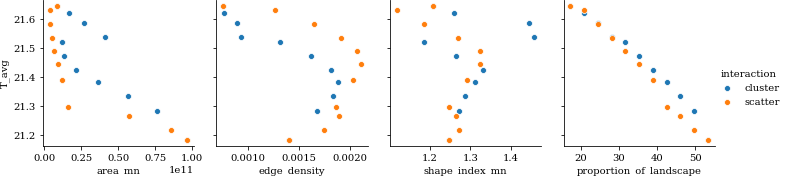

In [39]:
sns.pairplot(scenario_metrics_df, hue='interaction', x_vars=metrics_cols, y_vars=['T_avg'])

In [28]:
sns.pairplot(scenario_metrics_df, hue='interaction', x_vars=metrics_cols[:-1], y_vars=['T_avg'], size=scenario_metrics_df['proportion_of_landscape'] )

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: setting an array element with a sequence.

In [30]:
g = sns.PairGrid(scenario_metrics_df, x_vars=metrics_cols, y_vars=['T_avg'])
g.map(sns.scatterplot, size=scenario_metrics_df['proportion_of_landscape'])

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 1080x1080 with 36 Axes>

ValueError: Could not interpret input 'proportion_of_landscape'

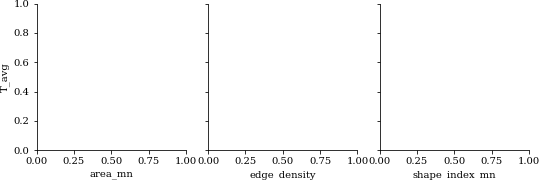

ValueError: Could not interpret input 'proportion_of_landscape'

In [23]:
sns.pairplot(scenario_metrics_df, hue='interaction', x_vars=metrics_cols[:-1], y_vars=['T_avg'], plot_kws=dict(size='proportion_of_landscape'))

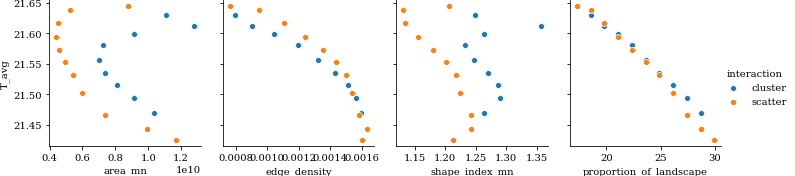

In [13]:
sns.pairplot(scenario_metrics_df, hue='interaction', x_vars=metrics_cols, y_vars=['T_avg'])

In [11]:
t_diff_da = sw.compute_t_diff_da(scenario_metrics_df.iloc[-1])

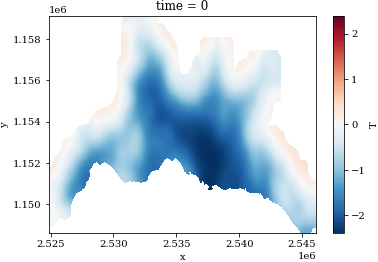

In [12]:
t_diff_da.plot()

In [19]:
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
ldf = sls.read_csv(statpop_filepath, x_column='E_KOORD', y_column='N_KOORD')
agglom_ldf = ldf.clip_by_geometry(geometry=agglom_extent_gdf.iloc[0]['geometry'], geometry_crs=agglom_extent_gdf.crs)

In [ ]:
agglom_ldf['B19BTOT']

In [ ]:
tmp_filepath = path.join(tmp_dir, 'age.tif')
tmp_col = 'tmp'
agglom_ldf[tmp_col] = agglom_ldf[get_age_columns(age_range)].sum(axis=1)
agglom_ldf.to_geotiff(tmp_filepath, tmp_col)
agglom_ldf = agglom_ldf.drop(tmp_col, axis=1)
return salem.open_xr_dataset(tmp_filepath)['data']


In [26]:
agglom_ldf.columns[agglom_ldf.columns.str.contains('TOT')]

Index(['B19BTOT', 'B19BMTOT', 'B19BWTOT'], dtype='object')

In [ ]:
sw = scenarios_utils.ScenarioWrapper(scenario_lulc_da, biophysical_table_filepath, ref_et_raster_filepath, t_ref, uhi_max, ucm_params, agglom_ldf)

In [9]:
scenario_metrics_df['T_avg'] = scenario_metrics_df.progress_apply(sw.compute_t_avg, axis=1)

  0%|          | 0/22 [00:00<?, ?it/s]

  9%|▉         | 2/22 [00:33<05:31, 16.56s/it]

 14%|█▎        | 3/22 [01:05<06:45, 21.36s/it]

 18%|█▊        | 4/22 [01:38<07:26, 24.81s/it]

 23%|██▎       | 5/22 [02:11<07:44, 27.31s/it]

 27%|██▋       | 6/22 [02:47<07:59, 29.95s/it]

 32%|███▏      | 7/22 [03:23<07:53, 31.58s/it]

 36%|███▋      | 8/22 [03:58<07:36, 32.58s/it]

 41%|████      | 9/22 [04:33<07:13, 33.35s/it]

 45%|████▌     | 10/22 [05:08<06:46, 33.86s/it]

 50%|█████     | 11/22 [05:44<06:18, 34.44s/it]

 55%|█████▍    | 12/22 [06:20<05:50, 35.06s/it]

 59%|█████▉    | 13/22 [06:56<05:18, 35.36s/it]

 64%|██████▎   | 14/22 [07:32<04:43, 35.42s/it]

 68%|██████▊   | 15/22 [08:08<04:08, 35.56s/it]

 73%|███████▎  | 16/22 [08:43<03:32, 35.37s/it]

 77%|███████▋  | 17/22 [09:16<02:54, 34.87s/it]

 82%|████████▏ | 18/22 [09:50<02:18, 34.54s/it]

 86%|████████▋ | 19/22 [10:25<01:44, 34.67s/it]

 91%|█████████ | 20/22 [11:00<01:09, 34.89s/it]

 95%|█████████▌| 21/22 [11:36<00:35, 35.06s/it]

100%|██████████| 22/22 [12:11<00:00, 35.19s/it]

100%|██████████| 22/22 [12:48<00:00, 34.93s/it]

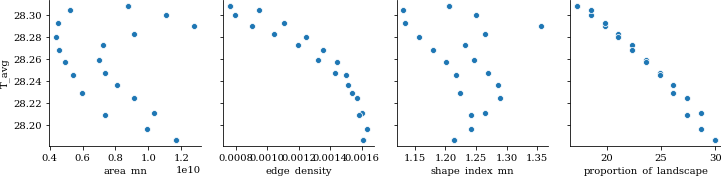

In [10]:
sns.pairplot(scenario_metrics_df, hue='interaction', x_vars=metrics_cols, y_vars=['T_avg'])

In [11]:
scenario_metrics_df['vuln_index'] = scenario_metrics_df.progress_apply(sw.compute_vuln_index, axis=1)

  0%|          | 0/22 [00:00<?, ?it/s]

  9%|▉         | 2/22 [00:34<05:41, 17.07s/it]

 14%|█▎        | 3/22 [01:09<07:07, 22.49s/it]

 18%|█▊        | 4/22 [01:44<07:56, 26.45s/it]

 23%|██▎       | 5/22 [02:20<08:15, 29.15s/it]

 27%|██▋       | 6/22 [02:53<08:07, 30.47s/it]

 32%|███▏      | 7/22 [03:28<07:57, 31.81s/it]

 36%|███▋      | 8/22 [04:02<07:34, 32.49s/it]

 41%|████      | 9/22 [04:35<07:03, 32.59s/it]

 45%|████▌     | 10/22 [05:09<06:33, 32.79s/it]

 50%|█████     | 11/22 [05:42<06:01, 32.91s/it]

 55%|█████▍    | 12/22 [06:15<05:29, 32.97s/it]

 59%|█████▉    | 13/22 [06:48<04:56, 32.90s/it]

 64%|██████▎   | 14/22 [07:20<04:23, 32.89s/it]

 68%|██████▊   | 15/22 [07:54<03:51, 33.04s/it]

 73%|███████▎  | 16/22 [08:27<03:18, 33.08s/it]

 77%|███████▋  | 17/22 [09:00<02:45, 33.11s/it]

 82%|████████▏ | 18/22 [09:34<02:13, 33.29s/it]

 86%|████████▋ | 19/22 [10:07<01:39, 33.19s/it]

 91%|█████████ | 20/22 [10:40<01:06, 33.19s/it]

 95%|█████████▌| 21/22 [11:13<00:33, 33.24s/it]

100%|██████████| 22/22 [11:46<00:00, 33.07s/it]

100%|██████████| 22/22 [12:19<00:00, 33.62s/it]

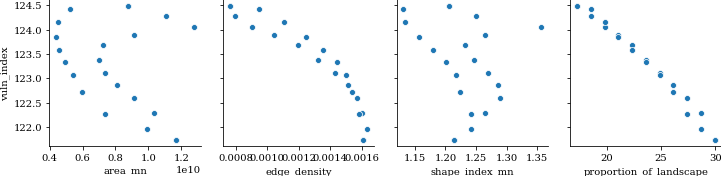

In [12]:
sns.pairplot(scenario_metrics_df, x_vars=metrics_cols, y_vars=['vuln_index'])

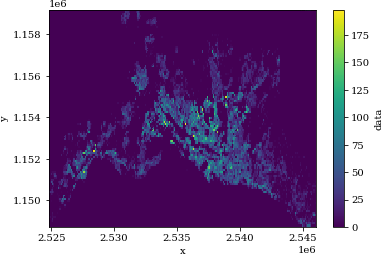

In [14]:
sw.vuln_da.plot()

In [19]:
t_da = xr.open_dataarray(t_da_filepath)
t_refs = t_da.min(dim=['x', 'y'])
uhi_maxs = t_da.max(dim=['x', 'y']) - t_refs

In [20]:
t_refs

<xarray.DataArray 'T' (time: 8)>
array([17.76161146, 19.56507229, 18.03189868, 15.69201509, 24.11556691,
       27.39900355, 20.01762114, 17.38123777])
Coordinates:
  * time     (time) datetime64[ns] 2018-05-25 2018-06-19 ... 2019-08-25

In [23]:
uhi_maxs

<xarray.DataArray 'T' (time: 8)>
array([2.89199095, 3.50345652, 3.91246846, 3.06607832, 2.60760465,
       2.50563944, 4.485815  , 3.62386679])
Coordinates:
  * time     (time) datetime64[ns] 2018-05-25 2018-06-19 ... 2019-08-25

In [16]:
t_da = sw.compute_t_da(scenario_metrics_df.iloc[0])

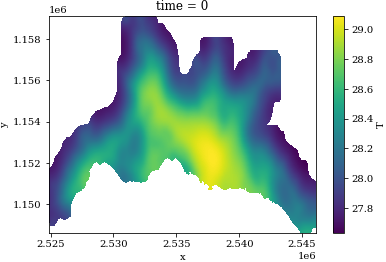

In [18]:
t_da.plot()

In [71]:
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
ldf = sls.read_csv(statpop_filepath, x_column='E_KOORD', y_column='N_KOORD')
agglom_ldf = ldf.clip_by_geometry(geometry=agglom_extent_gdf.iloc[0]['geometry'], geometry_crs=agglom_extent_gdf.crs)

In [127]:
def get_age_columns(age_range):
    return [f'B19B{sex}{age_group:02}' for sex in ['M', 'W']
            for age_group in age_range]

def get_age_da(agglom_ldf, age_range, tmp_dir):
    tmp_filepath = path.join(tmp_dir, 'age.tif')
    tmp_col = 'tmp'
    agglom_ldf[tmp_col] = agglom_ldf[get_age_columns(age_range)].sum(axis=1)
    agglom_ldf.to_geotiff(tmp_filepath, tmp_col)
    agglom_ldf = agglom_ldf.drop(tmp_col, axis=1)
    return salem.open_xr_dataset(tmp_filepath)['data']

def get_age_da_component(agglom_ldf, age_group, age_group_dict, tmp_dir):
    return age_group_dict[age_group][1] * get_age_da(agglom_ldf, age_group_dict[age_group][0], tmp_dir).astype(float)

# vulnerable_columns = [
#     f'B18B{sex}{age_group:02}' for sex in ['M', 'W']
#     for age_group in list(range(1, 4)) + list(range(13, 20))
# ]
# agglom_ldf['vulnerable'] = agglom_ldf[vulnerable_columns].sum(axis=1)
age_group_dict = {
    '0-19': (range(1, 5), 1),
    '20-44': (range(5, 10), 1),
    '45-64': (range(10, 12), 1.39),
    '65+': (range(12, 20), 2.35)
}
with tempfile.TemporaryDirectory() as tmp_dir:
    tmp_filepath = path.join(tmp_dir, 'vulnerable.tif')
    age_group_iterator = iter(age_group_dict)
    age_group = next(age_group_iterator)
    vuln_da = get_age_da(agglom_ldf, age_group_dict[age_group][0], tmp_dir)
    attrs = vuln_da.attrs.copy()
    vuln_da = age_group_dict[age_group][1] * vuln_da.astype(float)
    for age_group in age_group_iterator:
        vuln_da += age_group_dict[age_group][1] * get_age_da(agglom_ldf, age_group_dict[age_group][0], tmp_dir).astype(float)
    vuln_da.attrs = attrs        
    # vuln_ds = xr.Dataset({age_group: get_age_da(agglom_ldf, age_group_dict[age_group][0], tmp_dir) for age_group in age_group_dict})

In [129]:
t_hottest_day_da = suhi.align_ds(t_da.isel(time=t_da.groupby('time').max(dim=['x', 'y']).argmax()), vuln_da)
t_min = t_hottest_day_da.min()
vuln_index_da = vuln_da * (t_hottest_day_da - t_min) / (t_hottest_day_da.max() - t_min)

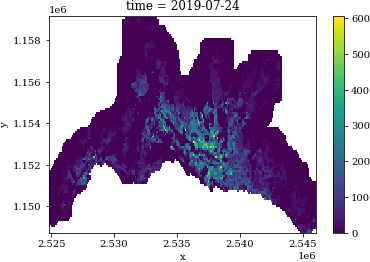

In [132]:
vuln_index_da.plot()

'2019-08-09'

In [ ]:
t_da = xr.open_dataarray(t_da_filepath)
hottest_day = t_da.isel(time=t_da.groupby('time').max(dim=['x', 'y']).argmax())['time'].dt.strftime('%Y-%m-%d').item()
# hottest_day = '2019-07-24'
t_ref = t_da.sel(time=hottest_day).min(dim=['x', 'y']).item()
uhi_max = t_da.sel(time=hottest_day).max(dim=['x', 'y']).item() - t_ref

ref_et_da = xr.open_dataarray(ref_et_da_filepath).sel(time=hottest_day)
tmp_dir = tempfile.TemporaryDirectory()
# ref_et_raster_filepath = invest_utils.dump_ref_et_raster(
#     ref_et_da, hottest_day, tmp_dir, invest_utils.get_da_rio_meta(ref_et_da))
ref_et_raster_filepath = '../data/interim/ref_eto_2019-07-24.tif'